# Goal

Study the metric for $k$-means clustering I developed in the recent version of my CompanyAboutUs notebook.

First step: generate data that has a given number of clusters in $n$-dimensional space.



In [1]:
import numpy as np # linear algebra
from scipy.stats import ortho_group # more linear algebra
import pandas as pd # excel for nerds
import matplotlib.pyplot as plt # plotting
import seaborn as sns # better plotting

In [2]:
rng = np.random.default_rng(seed=42)

This next functions produce a dataframe in **ndim** dimensions with **num_clusters** clusters. The clusters are multivariate normal distributions, with randomly sampled standard deviations (uniform in a given range). 

In [3]:
debug = False

def ProduceNClusters(num_clusters,num_ave_samples,centroid_range=5,ndim = 2):
    """
    Produce n-dimensional random points distributed in 
    
    :param num_clusters: Number of clusters to use
    :param num_av e_no samples: Average number of points for each cluster
    :param centroid_range: Range (-centroid_range,centroid_range) in which centroids are located
    :param ndim: Number of dimensions to produce cluster ind
    """
    # Pick the centroids
    centroids=[] # list of coordinates (in list form) for each cluster
    
    #centroid_sigmas=[] # list of standard deviations per cluster
    # Can use different sigmas per dimension per cluster
    centroid_sigmas=[] # list of n-dim sigmas per cluster
    # sigma limits fine-tuned for fun
    min_centroid_sigma = 0.05 * centroid_range
    max_centroid_sigma = 0.3  * centroid_range
    
    # sample number of samples per cluster with poisson (for now)
    # poisson distribution gives a distribution related to a 'counting' experiment
    centroid_n_samples = rng.poisson(num_ave_samples,num_clusters)
   
    # For producing rotated clusters (that don't have their principal axes all along the default axes)
    # we can use a multivariate sampling numpy.random.Generator.multivariate_normal
    # or use our current orthogonal normal distribution and perform our own rotation
    # Note that the multivariate method will perform the steps of diagonalizing the given covariance matrix
    # and essentially do the same thing as doing it manually. If we can define our own rotation matrix
    # that should save some time.
    rotation_matrices = []
    
    centroid_fractions=[] # what fractions of samples to take from this cluster
    for i in range(num_clusters):
        # create the centroid coordinates
        centroid_coordinates=rng.uniform(-centroid_range,centroid_range,ndim)
        centroids.append(centroid_coordinates)
        
        # create the cluster n-sigma 
        # the standard deviation in each dimension
        centroid_sigmas_local = rng.uniform(min_centroid_sigma,max_centroid_sigma,ndim)
        centroid_sigmas.append(centroid_sigmas_local)
        
        # sampling random orthogonal matrix for rotating the orthogonal multivariate distribution
        if ndim > 1:
            rot_matrix = ortho_group.rvs(dim=ndim)
        else:
            rot_matrix=[1]
        rotation_matrices.append(rot_matrix)
    
    cluster_coords=[]
    for i in range(num_clusters):
        cluster=[]
        for j in range(ndim):
            xi_values = rng.normal(centroids[i][j],centroid_sigmas[i][j],centroid_n_samples[i])
            cluster.append(xi_values)
        if ndim > 1:
            cluster = np.matmul(rotation_matrices[i],cluster)
        cluster_coords.append(cluster)
    
    total_array=[]
    for j in range(ndim+1):
        col_array = []
        total_array.append(col_array)

    for i in range(num_clusters):
        for k in range(centroid_n_samples[i]):
            
            # first array (index 0) is the cluster index
            # cluster as string
            total_array[0].append(f"{i}")

            # add the cluster coordinates
            for j in range(ndim):
                total_array[j+1].append(cluster_coords[i][j][k])
    
    df = pd.DataFrame(total_array).transpose()
    # set column names
    col_names = ['True Cluster']
    for i in range(ndim):
        col_names.append(f'x{i}')
    df.columns=col_names
    df['True Cluster'] = df['True Cluster'].astype("category")
    
    return df

  True Cluster        x0        x1        x2        x3        x4        x5
0            0   -3.8331 -5.736719  -2.21673 -0.677279 -0.140226 -0.997303
1            0 -3.352557 -6.083143 -2.564781 -2.079313  2.161943  -1.07294
2            0 -1.247461 -6.026772 -2.346797 -4.430312  2.574126  1.124213
3            0  -3.70221 -5.120919 -2.804638 -1.238115  2.742757  1.623085
4            0 -4.919376 -5.905331 -1.790485 -2.067418  1.516538 -0.087737


<Axes: xlabel='x0', ylabel='x1'>

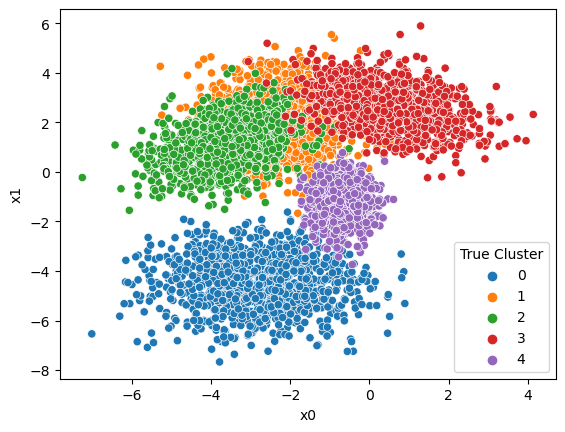

In [4]:
test_clustered_data = ProduceNClusters(5,1000,5,6)
variable_names=[]
for col in test_clustered_data.columns:
    if 'x' in col:
        variable_names.append(col)
print(test_clustered_data.head())
#sns.scatterplot(data=test_clustered_data,x=1,y=2,hue=0)
sns.scatterplot(data=test_clustered_data,x='x0',y='x1',hue='True Cluster')

<Axes: xlabel='x1', ylabel='x2'>

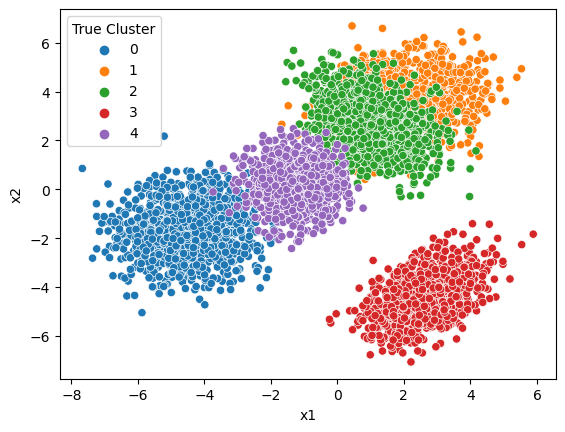

In [5]:
sns.scatterplot(data=test_clustered_data,x='x1',y='x2',hue='True Cluster')

## Experiment with clustering algorithms

In [6]:
from sklearn.cluster import KMeans

In [7]:
# data = test_clustered_data
k_means_5 = KMeans(n_clusters = 5,n_init=10)
#X = test_clustered_data.iloc[:,1:]
X = test_clustered_data.loc[:,variable_names]
# variable_names
print(X)
X_clustered_by_5 = k_means_5.fit_predict(X)

            x0        x1        x2        x3        x4        x5
0      -3.8331 -5.736719  -2.21673 -0.677279 -0.140226 -0.997303
1    -3.352557 -6.083143 -2.564781 -2.079313  2.161943  -1.07294
2    -1.247461 -6.026772 -2.346797 -4.430312  2.574126  1.124213
3     -3.70221 -5.120919 -2.804638 -1.238115  2.742757  1.623085
4    -4.919376 -5.905331 -1.790485 -2.067418  1.516538 -0.087737
...        ...       ...       ...       ...       ...       ...
5033 -0.486532 -0.421638  1.362573 -2.758263  1.673228  0.142624
5034 -0.309465 -0.314164  0.018155 -2.428654  1.474776  0.322226
5035 -0.641952 -2.253352  0.449316 -4.333028  3.397744  0.809623
5036 -0.907664 -2.025459  1.146046 -3.017701  2.091517  -1.32178
5037  -1.14101 -1.710875  0.706373 -2.654848   1.49851  0.774878

[5038 rows x 6 columns]


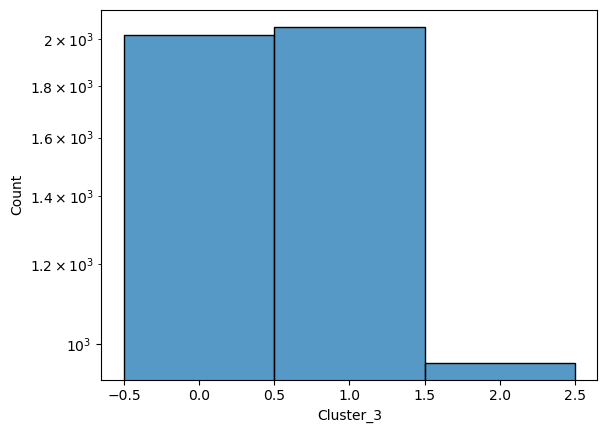

In [8]:
def ApplyClustering(main_data,vector_data,num_clusters,n_init):
    kmeans = KMeans(n_clusters = num_clusters,n_init=n_init)
    local_title = f"Cluster_{num_clusters}"
    
    main_data[local_title] = kmeans.fit_predict(vector_data)
    main_data[local_title] = main_data[local_title].astype("category")
    main_data[local_title].head(10)
    
ApplyClustering(test_clustered_data,X,3,20)
#about_data.head()
ax = sns.histplot(data=test_clustered_data,x="Cluster_3")
ax.set_yscale("log")

In [9]:
print(test_clustered_data)

     True Cluster        x0        x1        x2        x3        x4        x5  \
0               0   -3.8331 -5.736719  -2.21673 -0.677279 -0.140226 -0.997303   
1               0 -3.352557 -6.083143 -2.564781 -2.079313  2.161943  -1.07294   
2               0 -1.247461 -6.026772 -2.346797 -4.430312  2.574126  1.124213   
3               0  -3.70221 -5.120919 -2.804638 -1.238115  2.742757  1.623085   
4               0 -4.919376 -5.905331 -1.790485 -2.067418  1.516538 -0.087737   
...           ...       ...       ...       ...       ...       ...       ...   
5033            4 -0.486532 -0.421638  1.362573 -2.758263  1.673228  0.142624   
5034            4 -0.309465 -0.314164  0.018155 -2.428654  1.474776  0.322226   
5035            4 -0.641952 -2.253352  0.449316 -4.333028  3.397744  0.809623   
5036            4 -0.907664 -2.025459  1.146046 -3.017701  2.091517  -1.32178   
5037            4  -1.14101 -1.710875  0.706373 -2.654848   1.49851  0.774878   

     Cluster_3  
0         

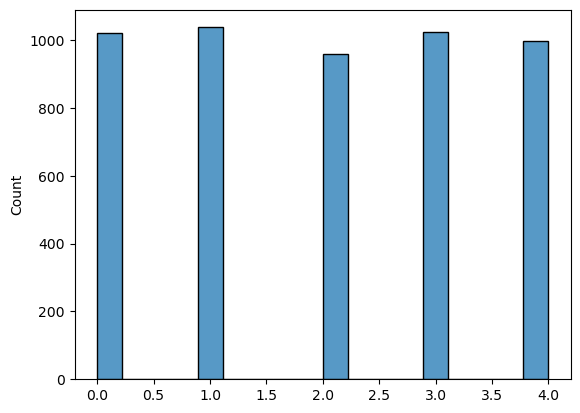

In [10]:
ax = sns.histplot(data=X_clustered_by_5)
#ax.set_yscale("log")

In [11]:
min_k = 2
max_k = 15

k_values = []
for k in range(min_k,max_k+1):
    k_values.append(k)
    ApplyClustering(test_clustered_data,X,k,30)

In [12]:
test_clustered_data.head()

,True Cluster,x0,x1,x2,x3,x4,x5,Cluster_3,Cluster_2,Cluster_4,...,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15
0,0,-3.8331,-5.736719,-2.21673,-0.677279,-0.140226,-0.997303,0,0,3,...,0,5,1,5,5,8,10,6,13,6
1,0,-3.352557,-6.083143,-2.564781,-2.079313,2.161943,-1.07294,0,0,3,...,0,5,1,5,5,4,6,11,13,11
2,0,-1.247461,-6.026772,-2.346797,-4.430312,2.574126,1.124213,0,0,3,...,5,3,5,0,9,4,6,11,8,11
3,0,-3.70221,-5.120919,-2.804638,-1.238115,2.742757,1.623085,0,0,3,...,5,3,5,0,9,4,6,11,8,11
4,0,-4.919376,-5.905331,-1.790485,-2.067418,1.516538,-0.087737,0,0,3,...,0,5,1,5,5,4,6,11,8,11


In [13]:
# More code copied form before

# return the entropy and the number of clusters with more than one entry
def ComputeColumnDistribution(data,column):
    list_col1 = data[column].to_list()
    list_col=[]
    for col in list_col1:
        list_col.append(col)
    hist_dict = {}
    total_count = len(list_col)
    for item in list_col:
        if item in hist_dict:
            hist_dict[item] = 1 + hist_dict[item]
        else:
            hist_dict[item] = 1
    entropy = 0
    count_of_clusters_with_multiple = 0
    for item,count in hist_dict.items():
        if count > 1:
            count_of_clusters_with_multiple += 1
        prob = float(count) / total_count
        entropy +=  - prob * np.log(prob)
    
        
    return entropy,count_of_clusters_with_multiple

entropy_3,mult_count_3 = ComputeColumnDistribution(test_clustered_data,'Cluster_3')
entropy_5,mult_count_5 = ComputeColumnDistribution(test_clustered_data,'Cluster_5')
entropy_12,mult_count_12 = ComputeColumnDistribution(test_clustered_data,'Cluster_12')

print(f"Test values for 3,5,12 are {entropy_3},{entropy_5},{entropy_12}")
print(f"Multi-entry count values for 3,5,12 are {mult_count_3},{mult_count_5},{mult_count_12}")

Test values for 3,5,12 are 1.0479058769949736,1.6090587689510016,2.4075652732169166
Multi-entry count values for 3,5,12 are 3,5,12


In [14]:
# Compute measurements
entropy_values = []
multcount_values = []
for k in range(min_k,max_k+1):

    entropy_k,mult_count = ComputeColumnDistribution(test_clustered_data,f'Cluster_{k}')
    entropy_values.append(entropy_k)
    multcount_values.append(mult_count)

print(k_values)
print(entropy_values)
print(multcount_values)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0.6716863081748752, 1.0479058769949736, 1.331846804026961, 1.6090587689510016, 1.7496595703394195, 1.8925724281495375, 2.033450982548973, 2.164613125645152, 2.246741382593417, 2.3305692923779766, 2.4075652732169166, 2.49023686543545, 2.548718147332687, 2.6837752654443285]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [15]:
entropy_df = pd.DataFrame(zip(k_values,entropy_values),columns=['k','Clustering Entropy'])


<Axes: xlabel='k', ylabel='Clustering Entropy'>

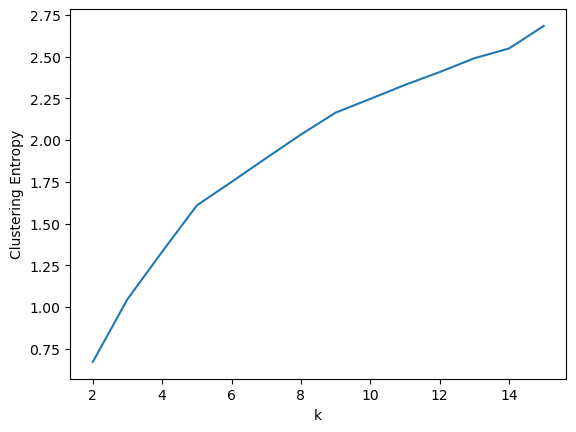

In [16]:
sns.lineplot(data=entropy_df,x='k',y='Clustering Entropy')

Some notes copied froma previous notebook, in which many clusters had only one entry, and this measure of entropy was studied.

The minimum clustering entropy seems to increase linearly with the number of categories. This might be easy to understand if it is just a matter of most $k$ values giving clusterings where almost all companies are in one cluster.



Recall the definition of entropy:

$$
H = \sum_x - p(x) \log(p(x))
$$

Suppose $x=1$ is the only cluster with more than one entry. Then, for $k$ clusters and $N$ entries $p(x=1) = \frac{N-(k-1)}{N}$ and $p(x) = \frac{1}{N}$ for $x\neq 1$

Then $H = -p(x=1)\log(p(x=1)) + \sum_{x\neq 1} -p(x) \log(p(x))$

There are $k-1$ clusters with $x\neq 1$

$H = - \frac{N-(k-1)}{N} \log (\frac{N-(k-1)}{N}) - (k-1)\frac{1}{N}\log(\frac{1}{N})$

$H = - \frac{1}{N} \left\{ (N-(k-1))\left[\log(N-(k-1)) - \log(N)\right] + (k-1) [-\log(N)] \right\}$

$H = - \frac{1}{N} \left\{ (N-(k-1))\log(N-(k-1)) - (N-(k-1))\log(N) - (k-1)\log(N) \right\}$

$H = - \frac{1}{N} \left\{ (N-(k-1))\log(N-(k-1)) - N\log(N) \right\}$

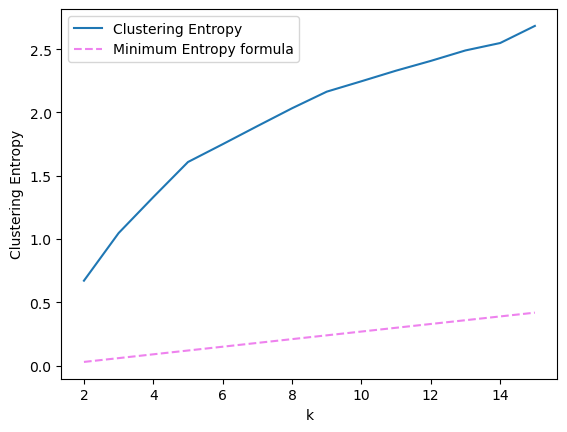

In [17]:
# Plotting this for comparison

ax = sns.lineplot(data=entropy_df,x='k',y='Clustering Entropy',label='Clustering Entropy')

N_total = 211.0

# $H = - \frac{N-(k-1)}{N} \log (\frac{N-(k-1)}{N}) - (k-1)\frac{1}{N}\log(\frac{1}{N})$
def f_exact(x):
    result = -((N_total - (x-1))/N_total) * np.log((N_total - (x - 1))/N_total)
    result += -((x-1)/N_total) * np.log(1/N_total)
    return result

x = np.linspace(min_k, max_k, 50)

plt.plot(x, f_exact(x), color='violet',linestyle='dashed',label='Minimum Entropy formula')

plt.legend()
plt.savefig('entropy_comparison.png')


This clears up the measurement a bit. We can define an adjusted entropy that does not have this trivial $k$-dependence. This can be done by subtracting or dividing by the minimum entropy formula. Which of these choices is better? My intuition would be to divide, assuming that the scale of 'noise' will also scale with the minimum entropy. This may be better justified by computing the maximum entropy, for which the size of each cluster is equal.

What is meant by 'noise'? Here, the signal is defined as the measurement of a true clustering

An interesting question: are these low entropy results common for 'bad' clustering? Is the feature of almost all entries ending up in one cluster relatively unique to this data set and analysis method?

For $N$ items in $k$ clusters, this means that $p(x) = \frac{N/k}{N} = \frac{1}{k}$. Then:

$$
H = -\sum_x \frac{1}{k} \log\left(\frac{1}{k}\right)
$$

$$
H = k \frac{1}{k} \log\left(k\right) = \log(k)
$$

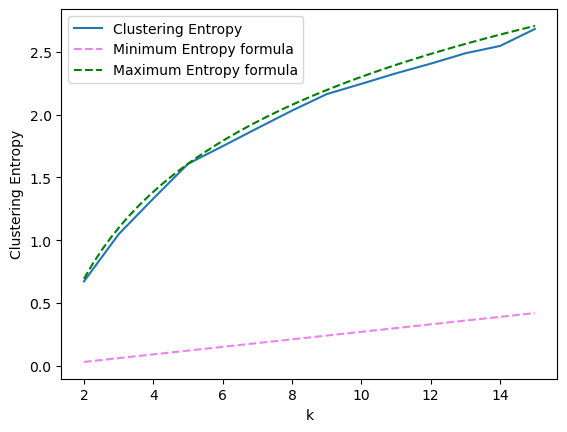

In [18]:
# Plotting this for comparison

ax = sns.lineplot(data=entropy_df,x='k',y='Clustering Entropy',label='Clustering Entropy')

#N_total = 211.0

# $H = - \frac{N-(k-1)}{N} \log (\frac{N-(k-1)}{N}) - (k-1)\frac{1}{N}\log(\frac{1}{N})$
def f_max_exact(x):
    return np.log(x)

x = np.linspace(min_k, max_k, 50)

plt.plot(x, f_exact(x), color='violet',linestyle='dashed',label='Minimum Entropy formula')
plt.plot(x, f_max_exact(x), color='green',linestyle='dashed',label='Maximum Entropy formula')


plt.legend()
plt.savefig('entropy_comparison_with_max.png')

We define the adjusted entropy ratio based on the ratio of the measured entropy to the minium entropy. We could also define it as the fraction of the distance between the minimum and maximum entropy values.

In [19]:
entropy_df['Min_Entropy'] = entropy_df['k'].apply(f_exact)
entropy_df['Max_Entropy'] = entropy_df['k'].apply(f_max_exact)

entropy_df['Scaled_Entropy_Ratio'] = (entropy_df['Clustering Entropy'] - entropy_df['Min_Entropy']) / (entropy_df['Max_Entropy'] - entropy_df['Min_Entropy'])
entropy_df

,k,Clustering Entropy,Min_Entropy,Max_Entropy,Scaled_Entropy_Ratio
0,2,0.671686,0.030092,0.693147,0.967633
1,3,1.047906,0.060162,1.098612,0.951171
2,4,1.331847,0.090209,1.386294,0.957991
3,5,1.609059,0.120234,1.609438,0.999745
4,6,1.749660,0.150235,1.791759,0.974353
5,7,1.892572,0.180213,1.945910,0.969792
6,8,2.033451,0.210169,2.079442,0.975397
7,9,2.164613,0.240101,2.197225,0.983337
8,10,2.246741,0.270009,2.302585,0.972526
9,11,2.330569,0.299895,2.397895,0.967909


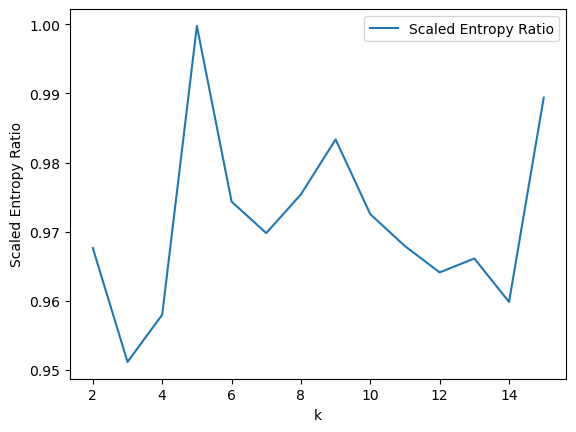

In [20]:

ax = sns.lineplot(data=entropy_df,x='k',y='Scaled_Entropy_Ratio',label='Scaled Entropy Ratio')
ax.set_ylabel('Scaled Entropy Ratio')
plt.savefig('scaled_entropy_ratio.png')

In [21]:
test_clustered_data_2 = ProduceNClusters(6,1000,5,2)


In [22]:
def ClusteringEntropyTest(df,min_k=2,max_k=15):
    variable_names=[]
    for col in df.columns:
        if 'x' in col:
            variable_names.append(col)
    
    X = df.loc[:,variable_names]
    k_values = []
    for k in range(min_k,max_k+1):
        k_values.append(k)
        ApplyClustering(df,X,k,10)
    
    # Compute measurements
    entropy_values = []
    multcount_values = []
    for k in range(min_k,max_k+1):

        entropy_k,mult_count = ComputeColumnDistribution(df,f'Cluster_{k}')
        entropy_values.append(entropy_k)
        multcount_values.append(mult_count)
    entropy_df = pd.DataFrame(zip(k_values,entropy_values),columns=['k','Clustering Entropy'])
    return entropy_df


def ComputeScaledEntropy(entropy_df):
    entropy_df['Min_Entropy'] = entropy_df['k'].apply(f_exact)
    entropy_df['Max_Entropy'] = entropy_df['k'].apply(f_max_exact)

    entropy_df['Scaled_Entropy_Ratio'] = (entropy_df['Clustering Entropy'] - entropy_df['Min_Entropy']) / (entropy_df['Max_Entropy'] - entropy_df['Min_Entropy'])
    return entropy_df




    k  Clustering Entropy
0   2            0.676565
1   3            1.081898
2   4            1.353254
3   5            1.587404
4   6            1.774810
5   7            1.888521
6   8            2.030746
7   9            2.137081
8  10            2.207214


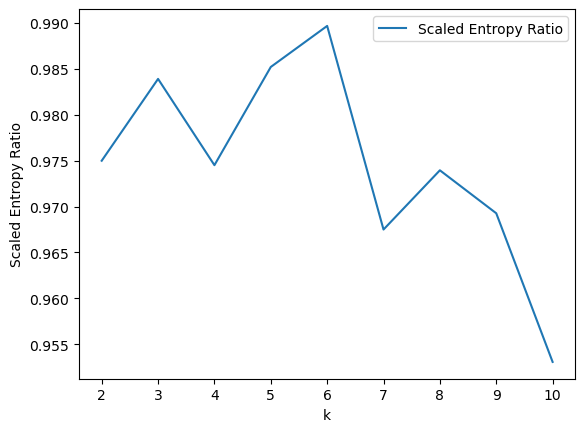

In [23]:
entropy_test_2 = ClusteringEntropyTest(test_clustered_data_2,max_k=10)
print(entropy_test_2)
entropy_test_2 = ComputeScaledEntropy(entropy_test_2)

entropy_test_2.head()

ax = sns.lineplot(data=entropy_test_2,x='k',y='Scaled_Entropy_Ratio',label='Scaled Entropy Ratio')
ax.set_ylabel('Scaled Entropy Ratio')
plt.savefig('scaled_entropy_ratio_2.png')

Iterate several tests with the same settings:

In [24]:
n_iterations = 10
n_true_clusters = 6
n_entries_per_cluster = 1000
n_data_range = 5
n_dimensions = 2

cluster_entropy_list=[]
for i in range(n_iterations):
    new_cluster_data = ProduceNClusters(n_true_clusters,n_entries_per_cluster,n_data_range,n_dimensions)
    computed_entropy = ClusteringEntropyTest(new_cluster_data,max_k=10)
    computed_entropy = ComputeScaledEntropy(computed_entropy)
    cluster_entropy_list.append(computed_entropy)

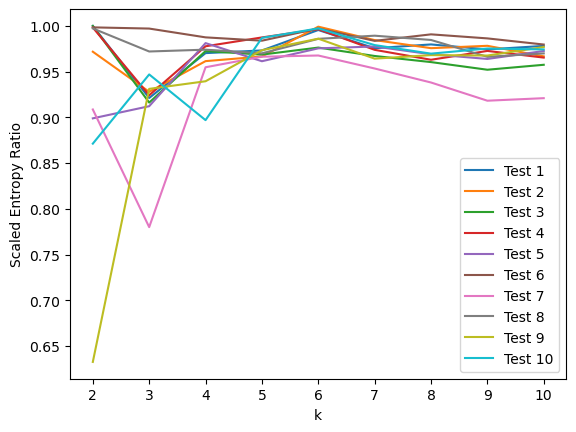

In [25]:
fig,ax = plt.subplots()
for i,cluster_entropy in enumerate(cluster_entropy_list):
    sns.lineplot(data=cluster_entropy,x='k',y='Scaled_Entropy_Ratio',label=f'Test {i+1}',ax=ax)
ax.set_ylabel('Scaled Entropy Ratio')
plt.savefig('scaled_entropy_ratio_scan_dim_2.png')

In [26]:
n_iterations = 10
n_true_clusters = 6
n_entries_per_cluster = 1000
n_data_range = 5
n_dimensions = 10

cluster_entropy_list=[]
for i in range(n_iterations):
    new_cluster_data = ProduceNClusters(n_true_clusters,n_entries_per_cluster,n_data_range,n_dimensions)
    computed_entropy = ClusteringEntropyTest(new_cluster_data,max_k=10)
    computed_entropy = ComputeScaledEntropy(computed_entropy)
    cluster_entropy_list.append(computed_entropy)


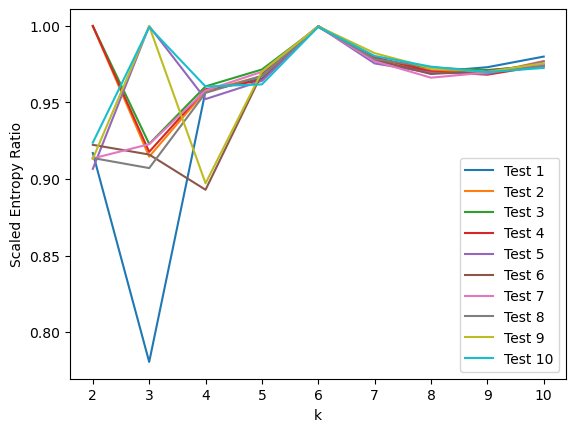

In [27]:
fig,ax = plt.subplots()
for i,cluster_entropy in enumerate(cluster_entropy_list):
    sns.lineplot(data=cluster_entropy,x='k',y='Scaled_Entropy_Ratio',label=f'Test {i+1}',ax=ax)
ax.set_ylabel('Scaled Entropy Ratio')
plt.savefig('scaled_entropy_ratio_scan_dim_10.png')

For n=2 dimensions, there is not typically a significant peak at the true number of clusters. However, as we increase the number of dimensions (keeping all other settings equal) the entropy measure becomes much more stable (consistent between different random starting conditions), and has a significant peak at the true number of clusters.
